# Network_Montpellier

Network_Montpellier is a python package that able to produce videos and widget representing a car, a pedestrian and a bicycle going from la maison du Lez to Place Eugène Bataillon in Montpellier with the shortest path possible.

* load the necessary packages for the report,
* print the shortest path between La Maison du Lez to Place Eugène Bataillon according to the type of transport,
* widget by the type of transport,
* animation which draw shortest path between La Maison du Lez to Place Eugène Bataillon according to the type of transport,
* calculate the distance between La Maison du Lez to Place Eugène Bataillon according to the type of transport,
* time study

## Loading packages

First, we start by loading the necessary packages

In [9]:
import sys
import os
import networkx as nx
import osmnx as ox
import numpy as np
# import matplotlib.animation as animation
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import clear_output
# from matplotlib.collections import LineCollection
%matplotlib notebook
ox.config(log_console=True, use_cache=True)


In order to use our functions to plot the shortest path and make animations, we have to import our package.

In [2]:
sys.path.append(os.path.dirname(
    os.path.abspath('network_montpellier')) + (os.path.sep + '..'))
import network_montpellier as net

## Shortest path between la Maison du Lez to Place Eugène Bataillon in Montpellier

* By walk

In [ ]:
net.type_transport('walk')

* By bike

In [ ]:
net.type_transport('bike')

* By car

In [ ]:
net.type_transport('drive')

## Widget by type of transport

In [ ]:
menu = [('car', 'drive'), ('bike', 'bike'), ('piedestrian', 'walk')]
interact(net.type_transport, transport=menu)

## Animation of a transport going from la maison du Lez to Place Eugène Bataillon in Montpellier with the shortest path possible

* By walk

In [ ]:
net.animation_type_transport('walk')

* By bike

In [ ]:
net.animation_type_transport('bike')

* By car

In [ ]:
net.animation_type_transport('drive')

## Distance in meters according to the type of transport  from La Maison du Lez to Place Eugène Bataillon

* By bike

In [59]:
print("The cycling distance between La Maison du Lez and Place Eugène Bataillon is " +
      str(net.distance_type_transport('bike')) + " meters")

The cycling distance between La Maison du Lez and Place Eugène Bataillon is 4339.373999999999 meters


* By walk

In [ ]:
net.distance_type_transport('walk')

* By car

In [ ]:
net.distance_type_transport('car')

## Time study

We will make a study of the time for each function according to the type of transport.

* By walk

In [12]:
times_walk_type_transport = net.times('walk', net.type_transport)
times_walk_distance = net.times('walk', net.distance_type_transport)
times_walk_animation = net.times('walk', net.animation_type_transport)
clear_output(wait=True)

103.89706659317017


* By bike

In [15]:
times_bike_type_transport = net.times('bike', net.type_transport)
times_bike_distance = net.times('bike', net.distance_type_transport)
times_bike_animation = net.times('bike', net.animation_type_transport)
clear_output(wait=True)

74.02999258041382


* By car

In [18]:
times_drive_type_transport = net.times('drive', net.type_transport)
times_drive_distance = net.times('drive', net.distance_type_transport)
times_drive_animation = net.times('drive', net.animation_type_transport)
clear_output(wait=True)

40.5629243850708


Let's do a histogram to see which type of transport takes the most time to compile for each function.

<IPython.core.display.Javascript object>


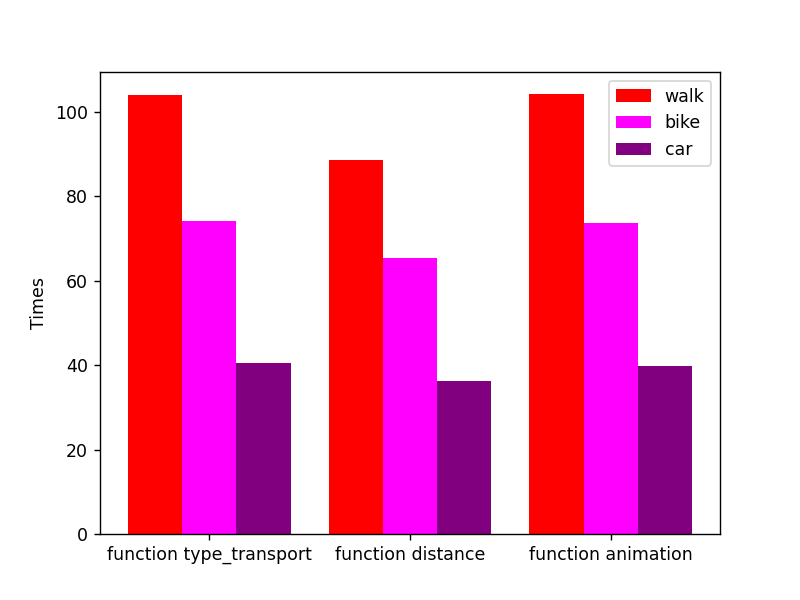

In [55]:
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = [times_walk_type_transport, times_walk_distance, times_walk_animation]
rects1 = ax.bar(ind, yvals, width, color='red')
zvals = [times_bike_type_transport, times_bike_distance, times_bike_animation]
rects2 = ax.bar(ind+width, zvals, width, color='magenta')
kvals = [times_drive_type_transport, times_drive_distance, times_drive_animation]
rects3 = ax.bar(ind+width*2, kvals, width, color='purple')

ax.set_ylabel('Times')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('function type_transport', 'function distance', 'function animation') )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('walk', 'bike', 'car') )

In [62]:
class network(object):
    def __init__(self, transport):
        self.transport = transport

    def distance(self, transport):
        G = ox.graph_from_place(
            'Montpellier, Hérault, France', network_type=transport)
        origin_point = ox.geo_utils.geocode(
            'Maison du Lez, Montpellier, France')
        destination_point = ox.geo_utils.geocode(
            'Place Eugène Bataillon, Montpellier, France')
        origin_node = ox.get_nearest_node(G, origin_point)
        destination_node = ox.get_nearest_node(G, destination_point)
        distance = nx.shortest_path_length(
            G, origin_node, destination_node, weight='length')
        return(distance)

In [70]:
truc = network(transport='bike')
print(truc.transport)
truc.distance(transport='bike')
print(truc.distance)
print(truc)

bike
<bound method network.distance of <__main__.network object at 0x0000021549A49388>>
